In [1]:
!pip install pyspark==2.4.6
!pip install thunder-python
!pip install showit
!pip install seaborn

In [2]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import thunder as td
from showit import image,tile

In [5]:
data=td.series.fromexample('fish',engine=sc)

In [6]:
data=data.toimages()

In [7]:
print(data)

Images
mode: spark
dtype: uint8
shape: (20, 76, 87, 2)


In [8]:
img = data.first()

([<matplotlib.image.AxesImage at 0x7f26d5138e10>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f26d516c0b8>)

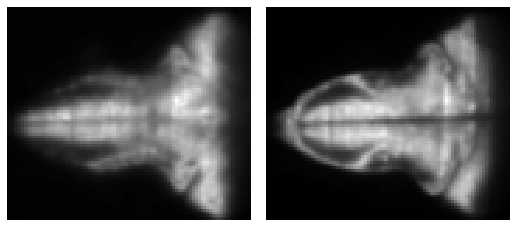

In [9]:
tile(img, axis = 2)

In [10]:
subsampled = data.subsample((5,5,1))
print(subsampled)

Images
mode: spark
dtype: uint8
shape: (20, 16, 18, 2)


/usr/local/lib/python3.6/dist-packages/thunder/images/images.py:320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.map(lambda v: v[slices], value_shape=new_value_shape)


([<matplotlib.image.AxesImage at 0x7f26d4ceee48>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f26d4d1ca58>)

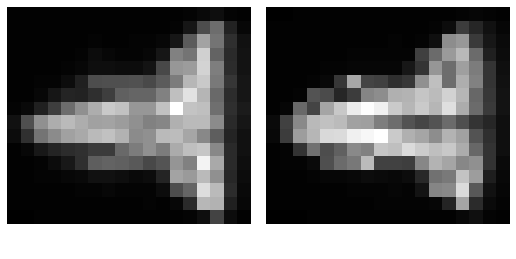

In [11]:
tile(subsampled.first(), axis=2)

In [12]:
statistics = data.std()

print(statistics)

Images
mode: local
dtype: float64
shape: (1, 76, 87, 2)


([<matplotlib.image.AxesImage at 0x7f26d4ab6d30>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f26d4c7a780>)

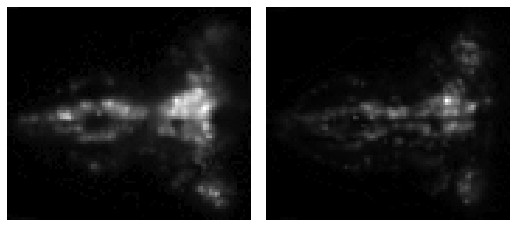

In [13]:
tile(statistics[0], axis=2)

In [14]:
series = data.toseries()

In [15]:
print(series)

Series
mode: spark
dtype: uint8
shape: (76, 87, 2, 20)


In [16]:
print(series.index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [17]:
print(series.count())

13224


In [18]:
series.flatten().shape

(13224, 20)

In [19]:
samples = series.flatten().filter(lambda x: x.std()>6).normalize().sample(n=50).toarray()

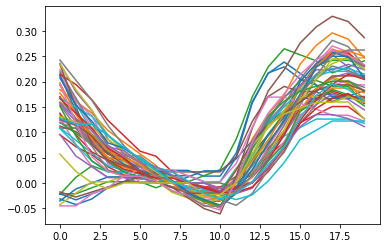

In [20]:
plt.plot(samples.T)

In [21]:
images = td.images.frombinary("Data/fish-long", order = 'F', engine =sc)
series = images.toseries()
print(series.shape)

(76, 87, 2, 240)


In [22]:
normalized = series.normalize(method='mean')

In [23]:
stddevs = normalized.map(lambda s: s.std()).sample(1000)

(array([403., 169., 139.,  61.,  56.,  40.,  27.,  22.,  14.,  18.,  11.,
          7.,  10.,   9.,   7.,   1.,   3.,   1.,   1.,   1.]),
 array([0.     , 0.00832, 0.01665, 0.02498, 0.0333 , 0.04163, 0.04996,
        0.0583 , 0.0666 , 0.07495, 0.08325, 0.09155, 0.0999 , 0.1082 ,
        0.1166 , 0.1249 , 0.1332 , 0.1415 , 0.1499 , 0.1582 , 0.1665 ],
       dtype=float16),
 <BarContainer object of 20 artists>)

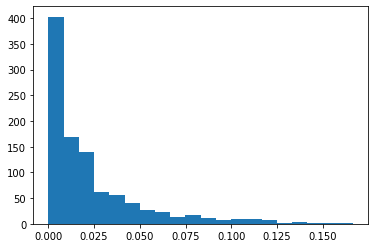

In [24]:
plt.hist(stddevs.values, bins=20)

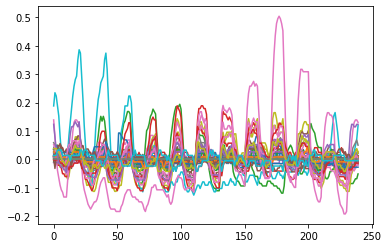

In [25]:
plt.plot(normalized.sample(50).values.T)

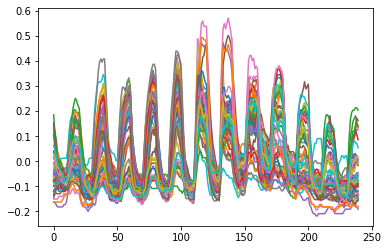

In [26]:
plt.plot(normalized.filter(lambda s: s.std()>= 0.1).sample(50).values.T)

In [27]:
from pyspark.mllib.clustering import KMeans

In [28]:
ks=[5,10,15,20,30,50,100,200]

In [29]:
models = []

In [30]:
for k in ks:
    models.append(KMeans.train(normalized.values._rdd.values(),k))

In [31]:
def model_error(model):
    return model.computeCost(normalized.values._rdd.values())

In [32]:
import numpy as np

In [33]:
errors = []
for i in range(8):
    errors.append(model_error(models[i]))

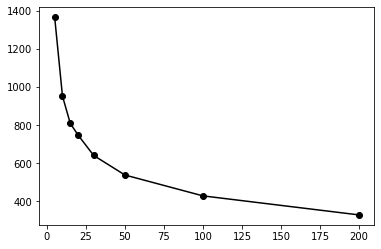

In [34]:
plt.plot(ks, errors, 'k-o')

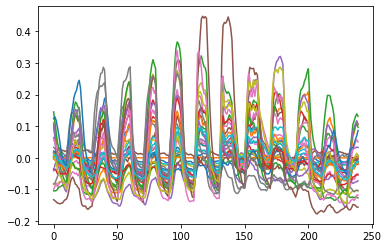

In [35]:
model30 = models[4]
plt.plot(np.asarray(model30.centers).T)

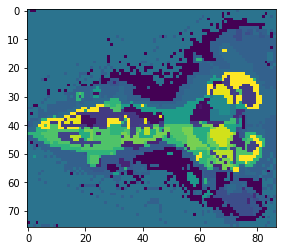

In [36]:
import seaborn as sns
from matplotlib.colors import ListedColormap
cmap_cat = ListedColormap(sns.color_palette("hls", 10), name='from_list')
by_cluster = normalized.map(lambda x: model30.predict(x)).toarray()
plt.imshow(by_cluster[:,:,0], interpolation='nearest', aspect='equal')